In [1]:
import os
_, current_folder_name = os.path.split(os.getcwd())
if current_folder_name == "notebooks":
    os.chdir("..")  
print(os.getcwd())  

/gpfs/data/oermannlab/users/ngok02/ModelCollapse/vae


In [2]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets
from torch.utils.data import DataLoader, TensorDataset, ConcatDataset
from torchvision.transforms import ToTensor
from itertools import chain
import copy
import math
from torch.autograd import Variable
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import numpy as np
from collapse import collapse
from einops.layers.torch import Rearrange

In [3]:
latent_dims = 20
num_epochs = 30
batch_size = 256
collapse_size = 2560
patch_size = 4
emb_size = 32
height = width = 28
capacity = 64
learning_rate = 1e-3
variational_beta = 1
alpha = 0.1
gamma=15
nl_stdev = 1
ng_stdev = 100
generations = 20

In [4]:
train_dataset = datasets.MNIST(root='../data', train = True, download = True, transform = ToTensor())
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = datasets.MNIST(root='../data', train = False, download = True, transform = ToTensor())
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [5]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

# Initial VAE-GAN

In [6]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        c = capacity
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=c, kernel_size=4, stride=2, padding=1) # out: c x 14 x 14
        self.conv2 = nn.Conv2d(in_channels=c, out_channels=c*2, kernel_size=4, stride=2, padding=1) # out: c x 7 x 7
        self.fc_mu = nn.Linear(in_features=c*2*7*7, out_features=latent_dims)
        self.fc_logvar = nn.Linear(in_features=c*2*7*7, out_features=latent_dims)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1) # flatten batch of multi-channel feature maps to a batch of feature vectors
        x_mu = self.fc_mu(x)
        x_logvar = self.fc_logvar(x)
        return x_mu, x_logvar

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        c = capacity
        self.fc = nn.Linear(in_features=latent_dims, out_features=c*2*7*7)
        self.conv2 = nn.ConvTranspose2d(in_channels=c*2, out_channels=c, kernel_size=4, stride=2, padding=1)
        self.conv1 = nn.ConvTranspose2d(in_channels=c, out_channels=1, kernel_size=4, stride=2, padding=1)

    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), capacity*2, 7, 7) # unflatten batch of feature vectors to a batch of multi-channel feature maps
        x = F.relu(self.conv2(x))
        x = torch.sigmoid(self.conv1(x)) # last layer before output is sigmoid, since we are using BCE as reconstruction loss
        return x

class VariationalAutoencoder(nn.Module):
    def __init__(self):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        latent_mu, latent_logvar = self.encoder(x)
        latent = self.latent_sample(latent_mu, latent_logvar)
        x_recon = self.decoder(latent)
        return x_recon, latent_mu, latent_logvar

    def latent_sample(self, mu, logvar, sampleme=False):
        if self.training or sampleme:
            # the reparameterization trick
            std = logvar.mul(0.5).exp_()
            eps = torch.empty_like(std).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu

def vae_loss(recon_x, x, mu, logvar):
    # recon_x is the probability of a multivariate Bernoulli distribution p.
    # -log(p(x)) is then the pixel-wise binary cross-entropy.
    # Averaging or not averaging the binary cross-entropy over all pixels here
    # is a subtle detail with big effect on training, since it changes the weight
    # we need to pick for the other loss term by several orders of magnitude.
    # Not averaging is the direct implementation of the negative log likelihood,
    # but averaging makes the weight of the other loss term independent of the image resolution.
    recon_loss = F.binary_cross_entropy(recon_x.view(-1, 784), x.view(-1, 784), reduction='sum')

    # KL-divergence between the prior distribution over latent vectors
    # (the one we are going to sample from when generating new images)
    # and the distribution estimated by the generator for the given image.
    kldivergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return recon_loss + variational_beta * kldivergence

In [7]:
def train_vae_gen(vae, train_dataloader, sample_vae=False, sample_from=None, grad_noise=False, debug=False):
    vae = vae.to(device)

    if debug:
        num_params = sum(p.numel() for p in vae.parameters() if p.requires_grad)
        print('Number of parameters: %d' % num_params)

    optimizer = torch.optim.Adam(params=vae.parameters(), lr=learning_rate, weight_decay=1e-5)

    vae.train()

    train_loss_avg = []

    if debug:
        print('Training ...')
    for epoch in range(num_epochs):
        train_loss_avg.append(0)
        num_batches = 0
        
        for image_batch, _ in train_dataloader:

            image_batch = image_batch.to(device)

            if sample_vae:
                with torch.no_grad():
                    # image_batch = image_batch.to(device)
                    latent = torch.randn(image_batch.shape[0], latent_dims, device=device)
                    image_batch = sample_from.decoder(latent)

            # vae reconstruction
            image_batch_recon, latent_mu, latent_logvar = vae(image_batch)

            # reconstruction error
            loss = vae_loss(image_batch_recon, image_batch, latent_mu, latent_logvar)

            # backpropagation
            optimizer.zero_grad()
            loss.backward()
            if grad_noise:
                for p in vae.parameters():
                    p.grad = p.grad + torch.randn_like(p.grad) * ng_stdev

            # one step of the optmizer (using the gradients from backpropagation)
            optimizer.step()

            train_loss_avg[-1] += loss.item()
            num_batches += 1

        train_loss_avg[-1] /= num_batches
        if debug:
            print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))

In [8]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        c = capacity
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=c, kernel_size=4, stride=2, padding=1) # out: c x 14 x 14
        self.conv2 = nn.Conv2d(in_channels=c, out_channels=c*2, kernel_size=4, stride=2, padding=1) # out: c x 7 x 7
        self.fc_z = nn.Linear(in_features=c*2*7*7, out_features=latent_dims)
        self.fc_y = nn.Linear(in_features=latent_dims, out_features=1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1) # flatten batch of multi-channel feature maps to a batch of feature vectors
        xl = x
        z = F.relu(self.fc_z(x))
        y = torch.sigmoid(self.fc_y(z))
        return y, xl

In [9]:
vae_init = VariationalAutoencoder().to(device)

In [10]:
train_vae_gen(vae_init, train_dataloader, debug=True)

Number of parameters: 647081
Training ...
Epoch [1 / 30] average reconstruction error: 40929.594972
Epoch [2 / 30] average reconstruction error: 29119.452365
Epoch [3 / 30] average reconstruction error: 27852.760248
Epoch [4 / 30] average reconstruction error: 27270.815725
Epoch [5 / 30] average reconstruction error: 26917.079962
Epoch [6 / 30] average reconstruction error: 26680.908885
Epoch [7 / 30] average reconstruction error: 26483.499127
Epoch [8 / 30] average reconstruction error: 26324.931051
Epoch [9 / 30] average reconstruction error: 26207.726056
Epoch [10 / 30] average reconstruction error: 26098.865317
Epoch [11 / 30] average reconstruction error: 26010.087496
Epoch [12 / 30] average reconstruction error: 25912.817354
Epoch [13 / 30] average reconstruction error: 25847.361777
Epoch [14 / 30] average reconstruction error: 25738.601729
Epoch [15 / 30] average reconstruction error: 25681.087192
Epoch [16 / 30] average reconstruction error: 25614.310979
Epoch [17 / 30] average

In [19]:
# https://arxiv.org/pdf/1512.09300
# https://github.com/rishabhd786/VAE-GAN-PYTORCH/blob/master/main.py

vae = VariationalAutoencoder().to(device)
discrim = Discriminator().to(device)

criterion=nn.BCELoss().to(device)
optim_E=torch.optim.RMSprop(vae.encoder.parameters(), lr=learning_rate)
optim_D=torch.optim.RMSprop(vae.decoder.parameters(), lr=learning_rate)
optim_Dis=torch.optim.RMSprop(discrim.parameters(), lr=learning_rate*alpha)

for epoch in range(num_epochs):
    print(f"Epoch: {epoch}")
    prior_loss_list,gan_loss_list,recon_loss_list=[],[],[]
    dis_real_list,dis_fake_list,dis_prior_list=[],[],[]
    for i, (data,_) in enumerate(train_dataloader, 0):
        bs=data.size()[0]
        
        ones_label=Variable(torch.ones(bs,1)).to(device)
        zeros_label=Variable(torch.zeros(bs,1)).to(device)
        zeros_label1=Variable(torch.zeros(64,1)).to(device)
        datav = Variable(data).to(device)
        rec_enc, mean, logvar = vae(datav)
        z_p = Variable(torch.randn(64,latent_dims)).to(device)
        x_p_tilda = vae.decoder(z_p)
        
        output = discrim(datav)[0]
        errD_real = criterion(output, ones_label)
        dis_real_list.append(errD_real.item())
        output = discrim(rec_enc)[0]
        errD_rec_enc = criterion(output, zeros_label)
        dis_fake_list.append(errD_rec_enc.item())
        output = discrim(x_p_tilda)[0]
        errD_rec_noise = criterion(output, zeros_label1)
        dis_prior_list.append(errD_rec_noise.item())
        gan_loss = errD_real + errD_rec_enc + errD_rec_noise
        gan_loss_list.append(gan_loss.item())
        optim_Dis.zero_grad()
        gan_loss.backward(retain_graph=True)
        optim_Dis.step()
        
        
        output = discrim(datav)[0]
        errD_real = criterion(output, ones_label)
        output = discrim(rec_enc)[0]
        errD_rec_enc = criterion(output, zeros_label)
        output = discrim(x_p_tilda)[0]
        errD_rec_noise = criterion(output, zeros_label1)
        gan_loss = errD_real + errD_rec_enc + errD_rec_noise
        
        
        x_l_tilda = discrim(rec_enc)[1]
        x_l = discrim(datav)[1]
        rec_loss = ((x_l_tilda - x_l) ** 2).mean()
        err_dec = gamma * rec_loss - gan_loss 
        recon_loss_list.append(rec_loss.item())
        optim_D.zero_grad()
        err_dec.backward(retain_graph=True)
        optim_D.step()
        
        rec_enc, mean, logvar = vae(datav)
        x_l_tilda = discrim(rec_enc)[1]
        x_l = discrim(datav)[1]
        rec_loss = ((x_l_tilda - x_l) ** 2).mean()
        prior_loss = 1 + logvar - mean.pow(2) - logvar.exp()
        prior_loss = (-0.5 * torch.sum(prior_loss))/torch.numel(mean.data)
        prior_loss_list.append(prior_loss.item())
        err_enc = prior_loss + 5*rec_loss
        
        optim_E.zero_grad()
        err_enc.backward(retain_graph=True)
        optim_E.step()

Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29


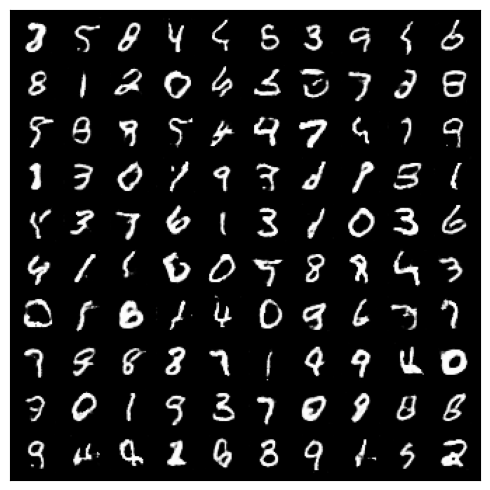

In [20]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import numpy as np

def to_img(x):
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

latent = torch.randn(128, latent_dims, device=device)

# reconstruct images from the latent vectors
img_recon = vae.decoder(latent)
img_recon = img_recon.cpu()

fig, ax = plt.subplots(figsize=(5, 5))
show_image(make_grid(img_recon.data[:100],10,5))
# plt.show()
plt.xticks([])
plt.yticks([])

plt.tight_layout()

In [21]:
from collapse import collapse

samples = []
loss = []
collapse(vae_init, vae, samples, loss, debug=True, discrim=discrim)

100%|██████████| 9.91M/9.91M [00:00<00:00, 71.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 3.21MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 23.7MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.04MB/s]


Generation 0
Generation 1
Generation 2
Generation 3
Generation 4
Generation 5
Generation 6
Generation 7
Generation 8
Generation 9
Generation 10
Generation 11
Generation 12
Generation 13
Generation 14
Generation 15
Generation 16
Generation 17
Generation 18
Generation 19


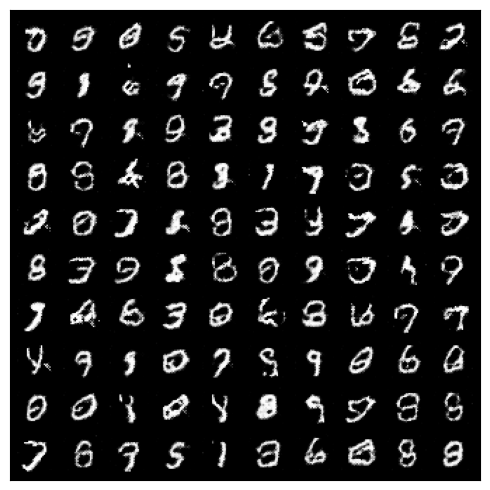

In [49]:
fig, ax = plt.subplots(figsize=(5, 5))
show_image(make_grid(samples[20].data[:100],10,5))
# plt.show()
plt.xticks([])
plt.yticks([])

plt.tight_layout()

# Secondary VAE-GAN
https://github.com/rishabhd786/VAE-GAN-PYTORCH/tree/master

In [66]:
import torchvision.transforms as transforms
import torchvision

In [67]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

class Encoder(nn.Module):
  def __init__(self):
    super(Encoder,self).__init__()
    self.conv1=nn.Conv2d(1,64,5,padding=2,stride=2)   #in_channels=3
    self.bn1=nn.BatchNorm2d(64,momentum=0.9)
    self.conv2=nn.Conv2d(64,128,5,padding=2,stride=2)
    self.bn2=nn.BatchNorm2d(128,momentum=0.9)
    self.conv3=nn.Conv2d(128,256,5,padding=2,stride=2)
    self.bn3=nn.BatchNorm2d(256,momentum=0.9)
    self.relu=nn.LeakyReLU(0.2)
    self.fc1=nn.Linear(256*8*8,2048)
    self.bn4=nn.BatchNorm1d(2048,momentum=0.9)
    self.fc_mean=nn.Linear(2048,128)
    self.fc_logvar=nn.Linear(2048,128)   #latent dim=128
  
  def forward(self,x):
    batch_size=x.size()[0]
    out=self.relu(self.bn1(self.conv1(x)))
    out=self.relu(self.bn2(self.conv2(out)))
    out=self.relu(self.bn3(self.conv3(out)))
    out=out.view(batch_size,-1)
    out=self.relu(self.bn4(self.fc1(out)))
    mean=self.fc_mean(out)
    logvar=self.fc_logvar(out)
    
    return mean,logvar
class Decoder(nn.Module):
  def __init__(self):
    super(Decoder,self).__init__()
    self.fc1=nn.Linear(128,8*8*256)
    self.bn1=nn.BatchNorm1d(8*8*256,momentum=0.9)
    self.relu=nn.LeakyReLU(0.2)
    self.deconv1=nn.ConvTranspose2d(256,256,6, stride=2, padding=2)
    self.bn2=nn.BatchNorm2d(256,momentum=0.9)
    self.deconv2=nn.ConvTranspose2d(256,128,6, stride=2, padding=2)
    self.bn3=nn.BatchNorm2d(128,momentum=0.9)
    self.deconv3=nn.ConvTranspose2d(128,32,6, stride=2, padding=2)
    self.bn4=nn.BatchNorm2d(32,momentum=0.9)
    self.deconv4=nn.ConvTranspose2d(32,1,5, stride=1, padding=2)
    self.tanh=nn.Tanh()

  def forward(self,x):
    batch_size=x.size()[0]
    x=self.relu(self.bn1(self.fc1(x)))
    x=x.view(-1,256,8,8)
    x=self.relu(self.bn2(self.deconv1(x)))
    x=self.relu(self.bn3(self.deconv2(x)))
    x=self.relu(self.bn4(self.deconv3(x)))
    x=self.tanh(self.deconv4(x))
    return x
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator,self).__init__()
    self.conv1=nn.Conv2d(1,32,5,padding=2,stride=1)
    self.relu=nn.LeakyReLU(0.2)
    self.conv2=nn.Conv2d(32,128,5,padding=2,stride=2)
    self.bn1=nn.BatchNorm2d(128,momentum=0.9)
    self.conv3=nn.Conv2d(128,256,5,padding=2,stride=2)
    self.bn2=nn.BatchNorm2d(256,momentum=0.9)
    self.conv4=nn.Conv2d(256,256,5,padding=2,stride=2)
    self.bn3=nn.BatchNorm2d(256,momentum=0.9)
    self.fc1=nn.Linear(8*8*256,512)
    self.bn4=nn.BatchNorm1d(512,momentum=0.9)
    self.fc2=nn.Linear(512,1)
    self.sigmoid=nn.Sigmoid()

  def forward(self,x):
    batch_size=x.size()[0]
    x=self.relu(self.conv1(x))
    x=self.relu(self.bn1(self.conv2(x)))
    x=self.relu(self.bn2(self.conv3(x)))
    x=self.relu(self.bn3(self.conv4(x)))
    x=x.view(-1,256*8*8)
    x1=x;
    x=self.relu(self.bn4(self.fc1(x)))
    x=self.sigmoid(self.fc2(x))

    return x,x1
class VAE_GAN(nn.Module):
  def __init__(self):
    super(VAE_GAN,self).__init__()
    self.encoder=Encoder()
    self.decoder=Decoder()
    self.discriminator=Discriminator()
    self.encoder.apply(weights_init)
    self.decoder.apply(weights_init)
    self.discriminator.apply(weights_init)


  def forward(self,x):
    bs=x.size()[0]
    z_mean,z_logvar=self.encoder(x)
    std = z_logvar.mul(0.5).exp_()
        
    #sampling epsilon from normal distribution
    epsilon=Variable(torch.randn(bs,128)).to(device)
    z=z_mean+std*epsilon
    x_tilda=self.decoder(z)
      
    return z_mean,z_logvar,x_tilda
    

In [70]:
def dataloader(batch_size):
  dataroot="./data"
  transform=transforms.Compose([ transforms.Resize(64),transforms.CenterCrop(64),transforms.ToTensor(),transforms.Normalize((0.5),(0.5))])
  dataset=torchvision.datasets.MNIST(root=dataroot, train=True,transform=transform, download=True)
  data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
  return data_loader

In [71]:
alpha = 0.1
gamma=15
data_loader=dataloader(64)

gen=VAE_GAN().to(device)
discrim=Discriminator().to(device)
real_batch = next(iter(data_loader))
# show_and_save("training" ,make_grid((real_batch[0]*0.5+0.5).cpu(),8))

epochs=25
lr=3e-4
alpha=0.1
gamma=15

criterion=nn.BCELoss().to(device)
optim_E=torch.optim.RMSprop(gen.encoder.parameters(), lr=lr)
optim_D=torch.optim.RMSprop(gen.decoder.parameters(), lr=lr)
optim_Dis=torch.optim.RMSprop(discrim.parameters(), lr=lr*alpha)
z_fixed=Variable(torch.randn((64,128))).to(device)
x_fixed=Variable(real_batch[0]).to(device)

for epoch in range(epochs):
  prior_loss_list,gan_loss_list,recon_loss_list=[],[],[]
  dis_real_list,dis_fake_list,dis_prior_list=[],[],[]
  for i, (data,_) in enumerate(data_loader, 0):
    bs=data.size()[0]
    
    ones_label=Variable(torch.ones(bs,1)).to(device)
    zeros_label=Variable(torch.zeros(bs,1)).to(device)
    zeros_label1=Variable(torch.zeros(64,1)).to(device)
    datav = Variable(data).to(device)
    mean, logvar, rec_enc = gen(datav)
    z_p = Variable(torch.randn(64,128)).to(device)
    x_p_tilda = gen.decoder(z_p)
 
    output = discrim(datav)[0]
    errD_real = criterion(output, ones_label)
    dis_real_list.append(errD_real.item())
    output = discrim(rec_enc)[0]
    errD_rec_enc = criterion(output, zeros_label)
    dis_fake_list.append(errD_rec_enc.item())
    output = discrim(x_p_tilda)[0]
    errD_rec_noise = criterion(output, zeros_label1)
    dis_prior_list.append(errD_rec_noise.item())
    gan_loss = errD_real + errD_rec_enc + errD_rec_noise
    gan_loss_list.append(gan_loss.item())
    optim_Dis.zero_grad()
    gan_loss.backward(retain_graph=True)
    optim_Dis.step()


    output = discrim(datav)[0]
    errD_real = criterion(output, ones_label)
    output = discrim(rec_enc)[0]
    errD_rec_enc = criterion(output, zeros_label)
    output = discrim(x_p_tilda)[0]
    errD_rec_noise = criterion(output, zeros_label1)
    gan_loss = errD_real + errD_rec_enc + errD_rec_noise
    

    x_l_tilda = discrim(rec_enc)[1]
    x_l = discrim(datav)[1]
    rec_loss = ((x_l_tilda - x_l) ** 2).mean()
    err_dec = gamma * rec_loss - gan_loss 
    recon_loss_list.append(rec_loss.item())
    optim_D.zero_grad()
    err_dec.backward(retain_graph=True)
    optim_D.step()
    
    mean, logvar, rec_enc = gen(datav)
    x_l_tilda = discrim(rec_enc)[1]
    x_l = discrim(datav)[1]
    rec_loss = ((x_l_tilda - x_l) ** 2).mean()
    prior_loss = 1 + logvar - mean.pow(2) - logvar.exp()
    prior_loss = (-0.5 * torch.sum(prior_loss))/torch.numel(mean.data)
    prior_loss_list.append(prior_loss.item())
    err_enc = prior_loss + 5*rec_loss

    optim_E.zero_grad()
    err_enc.backward(retain_graph=True)
    optim_E.step()
    
    if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_gan: %.4f\tLoss_prior: %.4f\tRec_loss: %.4f\tdis_real_loss: %0.4f\tdis_fake_loss: %.4f\tdis_prior_loss: %.4f'
                  % (epoch,epochs, i, len(data_loader),
                     gan_loss.item(), prior_loss.item(),rec_loss.item(),errD_real.item(),errD_rec_enc.item(),errD_rec_noise.item()))

[0/25][0/938]	Loss_gan: 2.6826	Loss_prior: 0.1316	Rec_loss: 0.7235	dis_real_loss: 1.0814	dis_fake_loss: 0.7817	dis_prior_loss: 0.8195
[0/25][50/938]	Loss_gan: 1.8632	Loss_prior: 0.3771	Rec_loss: 0.2492	dis_real_loss: 0.8202	dis_fake_loss: 0.5269	dis_prior_loss: 0.5160
[0/25][100/938]	Loss_gan: 1.7999	Loss_prior: 0.3648	Rec_loss: 0.1857	dis_real_loss: 0.8897	dis_fake_loss: 0.4725	dis_prior_loss: 0.4378
[0/25][150/938]	Loss_gan: 1.7516	Loss_prior: 0.3198	Rec_loss: 0.1849	dis_real_loss: 0.9191	dis_fake_loss: 0.4341	dis_prior_loss: 0.3983
[0/25][200/938]	Loss_gan: 1.7190	Loss_prior: 0.3371	Rec_loss: 0.1883	dis_real_loss: 0.9552	dis_fake_loss: 0.4050	dis_prior_loss: 0.3589
[0/25][250/938]	Loss_gan: 1.7364	Loss_prior: 0.3395	Rec_loss: 0.1738	dis_real_loss: 0.9438	dis_fake_loss: 0.4425	dis_prior_loss: 0.3501
[0/25][300/938]	Loss_gan: 1.6708	Loss_prior: 0.3273	Rec_loss: 0.1499	dis_real_loss: 0.9086	dis_fake_loss: 0.4415	dis_prior_loss: 0.3208
[0/25][350/938]	Loss_gan: 1.7133	Loss_prior: 0.3517

In [73]:
from torchvision.utils import make_grid

def to_img(x):
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

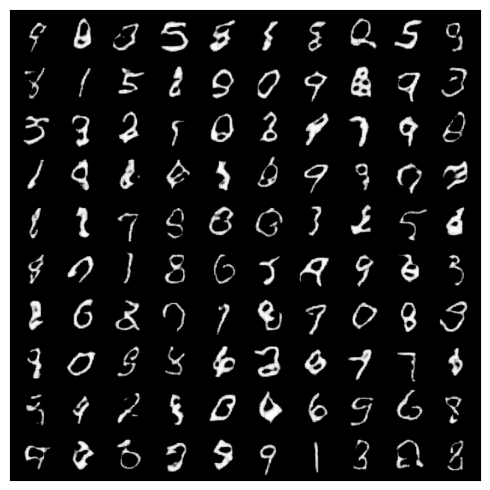

In [82]:
latent = torch.randn(100, 128).to(device)
sample = gen.decoder(latent).to("cpu")

plt.subplots(figsize=(5, 5))
show_image(make_grid(sample,10,5))

plt.xticks([])
plt.yticks([])
plt.tight_layout()

# VAE-GAN with Attention

In [71]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        c = capacity
        self.emb = nn.Conv2d(in_channels=1, out_channels=emb_size, kernel_size=1, stride=1)
        self.pe = PositionalEncoding2D(emb_size, height, width)
        self.att = Attention(dim=emb_size, n_heads=1)
        self.ln = nn.LayerNorm(emb_size)
        self.conv0 = nn.Conv2d(in_channels=emb_size, out_channels=1, kernel_size=1, stride=1)
        # self.conv1 = nn.Conv2d(in_channels=1, out_channels=c, kernel_size=4, stride=2, padding=1) # out: c x 14 x 14
        # self.conv2 = nn.Conv2d(in_channels=c, out_channels=c*2, kernel_size=4, stride=2, padding=1) # out: c x 7 x 7
        self.fc_mu = nn.Linear(in_features=28*28, out_features=latent_dims)
        self.fc_logvar = nn.Linear(in_features=28*28, out_features=latent_dims)

    def forward(self, x):
        x = self.emb(x)
        x = self.pe(x)
        x = x.view(x.size(0), x.size(1), -1)
        x = torch.permute(x, (2, 0, 1))
        x = self.ln(x + self.att(x))
        x = torch.permute(x, (1, 2, 0))
        x = x.view(x.size(0), x.size(1), height, width)
        x = F.relu(self.conv0(x))
        # x = F.relu(self.conv1(x))
        # x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1) # flatten batch of multi-channel feature maps to a batch of feature vectors
        x_mu = self.fc_mu(x)
        x_logvar = self.fc_logvar(x)
        return x_mu, x_logvar


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        c = capacity
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=c, kernel_size=4, stride=2, padding=1) # out: c x 14 x 14
        self.conv2 = nn.Conv2d(in_channels=c, out_channels=c*2, kernel_size=4, stride=2, padding=1) # out: c x 7 x 7
        self.fc_z = nn.Linear(in_features=c*2*7*7, out_features=latent_dims)
        self.fc_y = nn.Linear(in_features=latent_dims, out_features=1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1) # flatten batch of multi-channel feature maps to a batch of feature vectors
        xl = x
        z = F.relu(self.fc_z(x))
        y = torch.sigmoid(self.fc_y(z))
        return y, xl

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        c = capacity
        self.fc = nn.Linear(in_features=latent_dims, out_features=c*2*7*7)
        self.conv2 = nn.ConvTranspose2d(in_channels=c*2, out_channels=c, kernel_size=4, stride=2, padding=1)
        self.conv1 = nn.ConvTranspose2d(in_channels=c, out_channels=1, kernel_size=4, stride=2, padding=1)
        

    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), capacity*2, 7, 7) # unflatten batch of feature vectors to a batch of multi-channel feature maps
        x = F.relu(self.conv2(x))
        x = self.conv1(x) # last layer before output is sigmoid, since we are using BCE as reconstruction loss
        x = torch.sigmoid(x)
        return x

class VariationalAutoencoder(nn.Module):
    def __init__(self):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        latent_mu, latent_logvar = self.encoder(x)
        latent = self.latent_sample(latent_mu, latent_logvar)
        x_recon = self.decoder(latent)
        return x_recon, latent_mu, latent_logvar

    def latent_sample(self, mu, logvar, sampleme=False):
        if self.training or sampleme:
            # the reparameterization trick
            std = logvar.mul(0.5).exp_()
            eps = torch.empty_like(std).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu


class PositionalEncoding2D(nn.Module):
    def __init__(self, emb_size, height, width):
        super(PositionalEncoding2D, self).__init__()
        if emb_size % 4 != 0:
            raise ValueError("Cannot use sin/cos positional encoding with "
                             "odd dimension (got dim={:d})".format(emb_size))
        pos_w = torch.arange(width).unsqueeze(1).to(device)
        pos_h = torch.arange(height).unsqueeze(1).to(device)
        pe = torch.zeros(emb_size, height, width).to(device)
        emb_size = int(emb_size / 2)
        div_term = torch.exp(torch.arange(0, emb_size, 2) * (-math.log(10000.0) / emb_size)).to(device)
        pe[0:emb_size:2, :, :] = torch.sin(pos_w * div_term).transpose(0, 1).unsqueeze(1).repeat(1, height, 1)
        pe[1:emb_size:2, :, :] = torch.cos(pos_w * div_term).transpose(0, 1).unsqueeze(1).repeat(1, height, 1)
        pe[emb_size::2, :, :] = torch.sin(pos_h * div_term).transpose(0, 1).unsqueeze(2).repeat(1, 1, width)
        pe[emb_size + 1::2, :, :] = torch.cos(pos_h * div_term).transpose(0, 1).unsqueeze(2).repeat(1, 1, width)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return self.pe + x

class Attention(nn.Module):
    def __init__(self, dim, n_heads):
        super(Attention, self).__init__()
        self.n_heads = n_heads
        self.att = torch.nn.MultiheadAttention(embed_dim=dim, num_heads=n_heads)
        self.q = torch.nn.Linear(dim, dim)
        self.k = torch.nn.Linear(dim, dim)
        self.v = torch.nn.Linear(dim, dim)

    def forward(self, x):
        q = self.q(x)
        k = self.k(x)
        v = self.v(x)
        attn_output, attn_output_weights = self.att(q, k, v)
        return attn_output

In [72]:
for image_batch, _ in train_dataloader:
    image_batch = image_batch.to(device)
    print(image_batch.shape)

    pe = PositionalEncoding2D(emb_size, height, width)
    print((image_batch + pe(image_batch)).shape)
    break

torch.Size([256, 1, 28, 28])
torch.Size([256, 32, 28, 28])


In [73]:
vae = VariationalAutoencoder().to(device)
discrim = Discriminator().to(device)

criterion=nn.BCELoss().to(device)
optim_E=torch.optim.RMSprop(vae.encoder.parameters(), lr=learning_rate)
optim_D=torch.optim.RMSprop(vae.decoder.parameters(), lr=learning_rate)
optim_Dis=torch.optim.RMSprop(discrim.parameters(), lr=learning_rate*alpha)

for epoch in range(num_epochs):
    print(f"Epoch: {epoch}")
    prior_loss_list,gan_loss_list,recon_loss_list=[],[],[]
    dis_real_list,dis_fake_list,dis_prior_list=[],[],[]
    for i, (data,_) in enumerate(train_dataloader, 0):
        bs=data.size()[0]
        
        ones_label=Variable(torch.ones(bs,1)).to(device)
        zeros_label=Variable(torch.zeros(bs,1)).to(device)
        zeros_label1=Variable(torch.zeros(64,1)).to(device)
        datav = Variable(data).to(device)
        rec_enc, mean, logvar = vae(datav)
        z_p = Variable(torch.randn(64,latent_dims)).to(device)
        x_p_tilda = vae.decoder(z_p)
        
        output = discrim(datav)[0]
        errD_real = criterion(output, ones_label)
        dis_real_list.append(errD_real.item())
        output = discrim(rec_enc)[0]
        errD_rec_enc = criterion(output, zeros_label)
        dis_fake_list.append(errD_rec_enc.item())
        output = discrim(x_p_tilda)[0]
        errD_rec_noise = criterion(output, zeros_label1)
        dis_prior_list.append(errD_rec_noise.item())
        gan_loss = errD_real + errD_rec_enc + errD_rec_noise
        gan_loss_list.append(gan_loss.item())
        optim_Dis.zero_grad()
        gan_loss.backward(retain_graph=True)
        optim_Dis.step()
        
        
        output = discrim(datav)[0]
        errD_real = criterion(output, ones_label)
        output = discrim(rec_enc)[0]
        errD_rec_enc = criterion(output, zeros_label)
        output = discrim(x_p_tilda)[0]
        errD_rec_noise = criterion(output, zeros_label1)
        gan_loss = errD_real + errD_rec_enc + errD_rec_noise
        
        
        x_l_tilda = discrim(rec_enc)[1]
        x_l = discrim(datav)[1]
        rec_loss = ((x_l_tilda - x_l) ** 2).mean()
        err_dec = gamma * rec_loss - gan_loss 
        recon_loss_list.append(rec_loss.item())
        optim_D.zero_grad()
        err_dec.backward(retain_graph=True)
        optim_D.step()
        
        rec_enc, mean, logvar = vae(datav)
        x_l_tilda = discrim(rec_enc)[1]
        x_l = discrim(datav)[1]
        rec_loss = ((x_l_tilda - x_l) ** 2).mean()
        prior_loss = 1 + logvar - mean.pow(2) - logvar.exp()
        prior_loss = (-0.5 * torch.sum(prior_loss))/torch.numel(mean.data)
        prior_loss_list.append(prior_loss.item())
        err_enc = prior_loss + 5*rec_loss
        
        optim_E.zero_grad()
        err_enc.backward(retain_graph=True)
        optim_E.step()

Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29


torch.Size([100, 20])


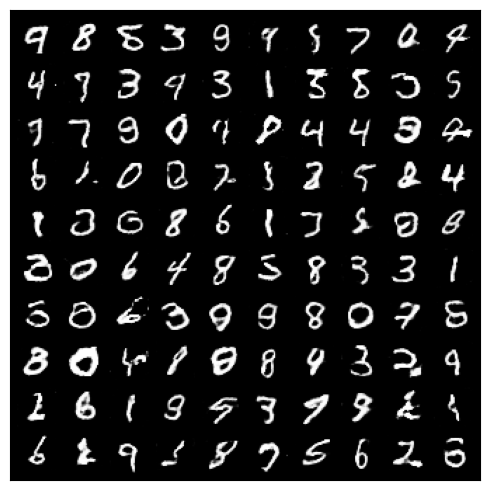

In [74]:

def to_img(x):
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

latent = torch.randn(100, latent_dims, device=device)
print(latent.shape)
# reconstruct images from the latent vectors
img_recon = vae.decoder(latent)
img_recon = img_recon.cpu()

fig, ax = plt.subplots(figsize=(5, 5))
show_image(make_grid(img_recon.data[:100],10,5))
# plt.show()
plt.xticks([])
plt.yticks([])

plt.tight_layout()

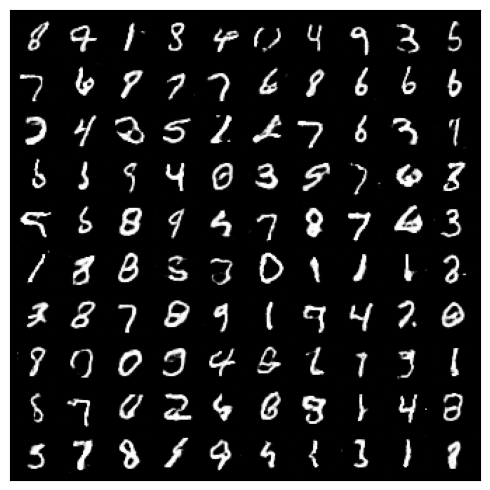

In [75]:
for image_batch, _ in train_dataloader:
    image_batch = image_batch.to(device)
    img_recon, _, _ = vae(image_batch)
    fig, ax = plt.subplots(figsize=(5, 5))
    show_image(make_grid(img_recon.cpu().data[:100],10,5))
    # plt.show()
    plt.xticks([])
    plt.yticks([])
    
    plt.tight_layout()
    break

In [76]:
samples = []
loss = []
collapse(vae_init, vae, samples, loss, debug=True, discrim=discrim, generations=50)

Generation 0
Generation 1
Generation 2
Generation 3
Generation 4
Generation 5
Generation 6
Generation 7
Generation 8
Generation 9
Generation 10
Generation 11
Generation 12
Generation 13
Generation 14
Generation 15
Generation 16
Generation 17
Generation 18
Generation 19
Generation 20
Generation 21
Generation 22
Generation 23
Generation 24
Generation 25
Generation 26
Generation 27
Generation 28
Generation 29
Generation 30
Generation 31
Generation 32
Generation 33
Generation 34
Generation 35
Generation 36
Generation 37
Generation 38
Generation 39
Generation 40
Generation 41
Generation 42
Generation 43
Generation 44
Generation 45
Generation 46
Generation 47
Generation 48
Generation 49


In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
show_image(make_grid(samples[50].data[:100],10,5))
# plt.show()
plt.xticks([])
plt.yticks([])

plt.tight_layout()

# Multiclass VAE-GAN

In [58]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        c = capacity
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=c, kernel_size=4, stride=2, padding=1) # out: c x 14 x 14
        self.conv2 = nn.Conv2d(in_channels=c, out_channels=c*2, kernel_size=4, stride=2, padding=1) # out: c x 7 x 7
        self.fc_mu = nn.Linear(in_features=c*2*7*7, out_features=latent_dims)
        self.fc_logvar = nn.Linear(in_features=c*2*7*7, out_features=latent_dims)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1) # flatten batch of multi-channel feature maps to a batch of feature vectors
        x_mu = self.fc_mu(x)
        x_logvar = self.fc_logvar(x)
        return x_mu, x_logvar

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        c = capacity
        self.fc = nn.Linear(in_features=latent_dims, out_features=c*2*7*7)
        self.conv2 = nn.ConvTranspose2d(in_channels=c*2, out_channels=c, kernel_size=4, stride=2, padding=1)
        self.conv1 = nn.ConvTranspose2d(in_channels=c, out_channels=1, kernel_size=4, stride=2, padding=1)

    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), capacity*2, 7, 7) # unflatten batch of feature vectors to a batch of multi-channel feature maps
        x = F.relu(self.conv2(x))
        x = torch.sigmoid(self.conv1(x)) # last layer before output is sigmoid, since we are using BCE as reconstruction loss
        return x

class VariationalAutoencoder(nn.Module):
    def __init__(self):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        latent_mu, latent_logvar = self.encoder(x)
        latent = self.latent_sample(latent_mu, latent_logvar)
        x_recon = self.decoder(latent)
        return x_recon, latent_mu, latent_logvar

    def latent_sample(self, mu, logvar, sampleme=False):
        if self.training or sampleme:
            # the reparameterization trick
            std = logvar.mul(0.5).exp_()
            eps = torch.empty_like(std).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        c = capacity
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=c, kernel_size=4, stride=2, padding=1) # out: c x 14 x 14
        self.conv2 = nn.Conv2d(in_channels=c, out_channels=c*2, kernel_size=4, stride=2, padding=1) # out: c x 7 x 7
        self.fc_z = nn.Linear(in_features=c*2*7*7, out_features=latent_dims)
        self.fc_y = nn.Linear(in_features=latent_dims, out_features=10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1) # flatten batch of multi-channel feature maps to a batch of feature vectors
        xl = x
        z = F.relu(self.fc_z(x))
        y = torch.sigmoid(self.fc_y(z))
        return y, xl

In [59]:
def train_vae_gan_multiclass(vae, discrim, train_dataloader, debug=False):
    criterion=nn.BCELoss().to(device)
    optim_E=torch.optim.RMSprop(vae.encoder.parameters(), lr=learning_rate)
    optim_D=torch.optim.RMSprop(vae.decoder.parameters(), lr=learning_rate)
    optim_Dis=torch.optim.RMSprop(discrim.parameters(), lr=learning_rate*alpha)
    
    for epoch in range(num_epochs):
        if debug:
            print(f"Epoch: {epoch}")
        prior_loss_list,gan_loss_list,recon_loss_list=[],[],[]
        dis_real_list,dis_fake_list,dis_prior_list=[],[],[]
        for i, (data,targets) in enumerate(train_dataloader, 0):
            bs=data.size()[0]
            if len(targets.shape) == 1:
                ones_label=Variable(F.one_hot(targets)).float().to(device)
            else:
                ones_label=Variable(targets).to(device)
            zeros_label=Variable(torch.zeros(bs,10)).to(device)
            zeros_label1=Variable(torch.zeros(64,10)).to(device)
            datav = Variable(data).to(device)
            rec_enc, mean, logvar = vae(datav)
            z_p = Variable(torch.randn(64,latent_dims)).to(device)
            x_p_tilda = vae.decoder(z_p)
            
            output = discrim(datav)[0]
            errD_real = criterion(output, ones_label)
            dis_real_list.append(errD_real.item())
            output = discrim(rec_enc)[0]
            errD_rec_enc = criterion(output, zeros_label)
            dis_fake_list.append(errD_rec_enc.item())
            output = discrim(x_p_tilda)[0]
            errD_rec_noise = criterion(output, zeros_label1)
            dis_prior_list.append(errD_rec_noise.item())
            gan_loss = errD_real + errD_rec_enc + errD_rec_noise
            gan_loss_list.append(gan_loss.item())
            optim_Dis.zero_grad()
            gan_loss.backward(retain_graph=True)
            optim_Dis.step()
            
            
            output = discrim(datav)[0]
            errD_real = criterion(output, ones_label)
            output = discrim(rec_enc)[0]
            errD_rec_enc = criterion(output, zeros_label)
            output = discrim(x_p_tilda)[0]
            errD_rec_noise = criterion(output, zeros_label1)
            gan_loss = errD_real + errD_rec_enc + errD_rec_noise
            
            
            x_l_tilda = discrim(rec_enc)[1]
            x_l = discrim(datav)[1]
            rec_loss = ((x_l_tilda - x_l) ** 2).mean()
            err_dec = gamma * rec_loss - gan_loss 
            recon_loss_list.append(rec_loss.item())
            optim_D.zero_grad()
            err_dec.backward(retain_graph=True)
            optim_D.step()
            
            rec_enc, mean, logvar = vae(datav)
            x_l_tilda = discrim(rec_enc)[1]
            x_l = discrim(datav)[1]
            rec_loss = ((x_l_tilda - x_l) ** 2).mean()
            prior_loss = 1 + logvar - mean.pow(2) - logvar.exp()
            prior_loss = (-0.5 * torch.sum(prior_loss))/torch.numel(mean.data)
            prior_loss_list.append(prior_loss.item())
            err_enc = prior_loss + 5*rec_loss
            
            optim_E.zero_grad()
            err_enc.backward(retain_graph=True)
            optim_E.step()

In [60]:
vae = VariationalAutoencoder().to(device)
discrim = Discriminator().to(device)
train_vae_gan_multiclass(vae, discrim, train_dataloader, debug=True)

Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29


torch.Size([100, 20])


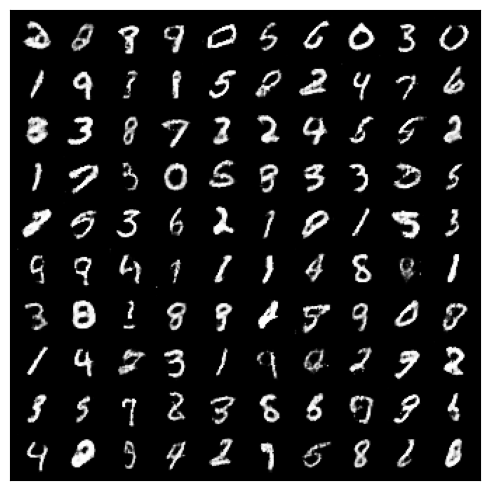

In [61]:
def to_img(x):
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

latent = torch.randn(100, latent_dims, device=device)
print(latent.shape)
# reconstruct images from the latent vectors
img_recon = vae.decoder(latent)
img_recon = img_recon.cpu()

fig, ax = plt.subplots(figsize=(5, 5))
show_image(make_grid(img_recon.data[:100],10,5))
# plt.show()
plt.xticks([])
plt.yticks([])

plt.tight_layout()

In [62]:
samples = []
loss = []
collapse(vae_init, vae, samples, loss, multiclass=True, debug=True, discrim=discrim, generations=50)

Generation 0
Generation 1
Generation 2
Generation 3
Generation 4
Generation 5
Generation 6
Generation 7
Generation 8
Generation 9
Generation 10
Generation 11
Generation 12
Generation 13
Generation 14
Generation 15
Generation 16
Generation 17
Generation 18
Generation 19
Generation 20
Generation 21
Generation 22
Generation 23
Generation 24
Generation 25
Generation 26
Generation 27
Generation 28
Generation 29
Generation 30
Generation 31
Generation 32
Generation 33
Generation 34
Generation 35
Generation 36
Generation 37
Generation 38
Generation 39
Generation 40
Generation 41
Generation 42
Generation 43
Generation 44
Generation 45
Generation 46
Generation 47
Generation 48
Generation 49


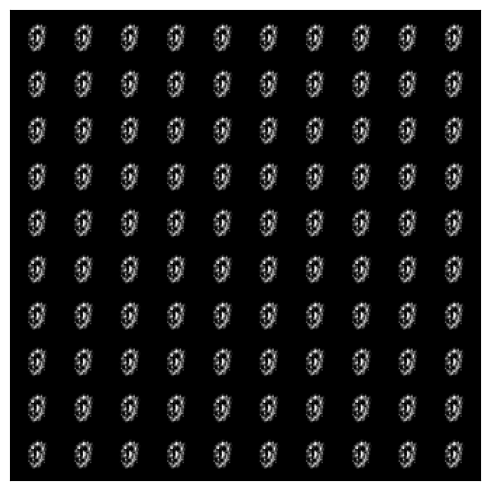

In [64]:
fig, ax = plt.subplots(figsize=(5, 5))
show_image(make_grid(samples[50].data[:100],10,5))
# plt.show()
plt.xticks([])
plt.yticks([])

plt.tight_layout()